# Principal Component Analysis & Featue Importance

## PCA

In [1]:
import pandas as pd
import dataframe_image as dfi
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# https://www.kaggle.com/datasets/saurabh00007/iriscsv
filename = 'Iris.csv'
df = pd.read_csv(filename, index_col=0)
cols_x = list(df.columns[0:4])
col_y = df.columns[4]
name_target = sorted(list(set(df[col_y])))

# model pipeline for PCA
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('PCA', PCA()),
])
features = df[cols_x]
pipe.fit(features)

# PCA scores
scores = pipe.transform(features)
df_pca = pd.DataFrame(
    scores,
    columns=["PC{}".format(x + 1) for x in range(scores.shape[1])],
    index=df.index
)
cols_pc = list(df_pca.columns)
df_pca.insert(0, col_y, df[col_y].copy())
dfi.export(df_pca.head(), 'table_061_iris_PCA.png')
df_pca.head()

/usr/bin/google-chrome


,Species,PC1,PC2,PC3,PC4
Id,,,,,
1,Iris-setosa,-2.264542,0.505704,-0.121943,-0.023073
2,Iris-setosa,-2.086426,-0.655405,-0.227251,-0.103208
3,Iris-setosa,-2.367950,-0.318477,0.051480,-0.027825
4,Iris-setosa,-2.304197,-0.575368,0.098860,0.066311
5,Iris-setosa,-2.388777,0.674767,0.021428,0.037397


## Scatter for PCs

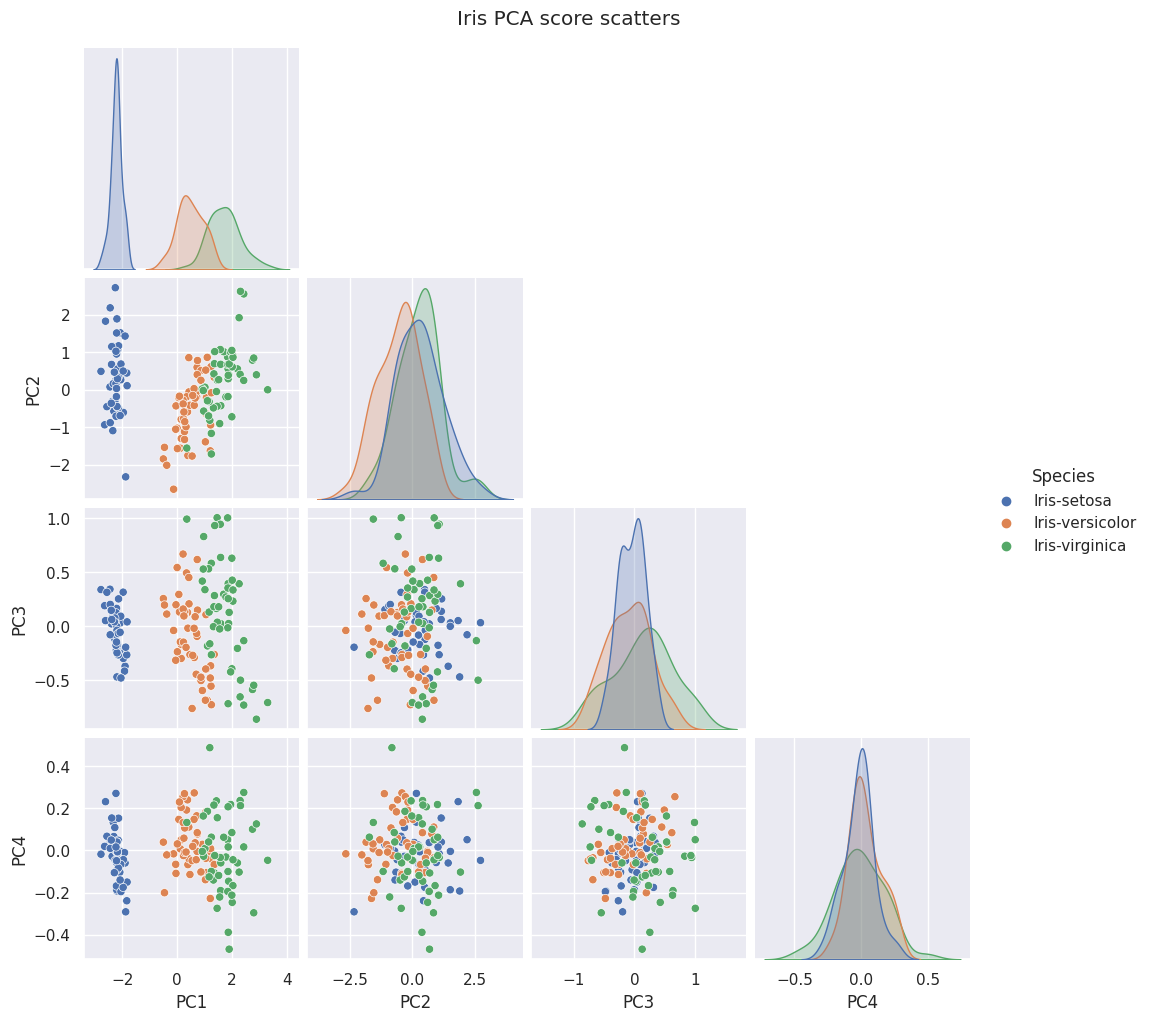

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 14
sns.set()

g = sns.pairplot(df_pca, hue=col_y, corner=True)
g.fig.suptitle('Iris PCA score scatters', y=1.02)

plt.savefig('iris_061_PCA_scatter.png')
plt.show()

## Identify 2 clusters

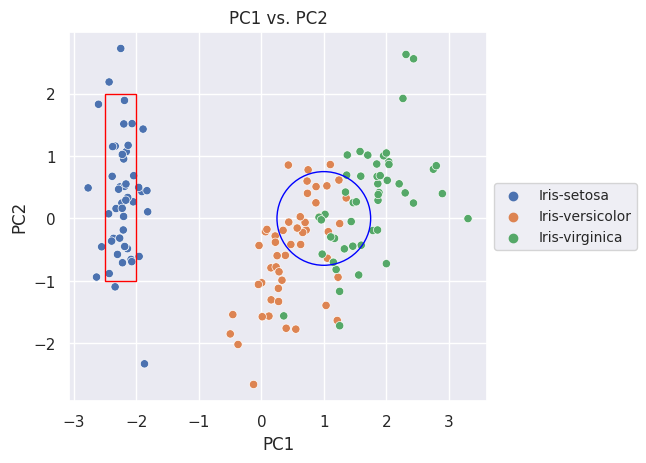

In [3]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=col_y, ax=ax)
ax.set_aspect('equal')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.set_title('PC1 vs. PC2')


x1 = -2.5
y1 = -1.0
w1 = 0.5
h1 = 3.0
c1 = patches.Rectangle(xy=(x1, y1) , width=w1, height=h1, fill=False, edgecolor='red')
ax.add_patch(c1)

x2 = 1.0
y2 = 0.0
r2 = 0.75
c2 = patches.Circle(xy=(x2, y2), radius=r2, fill=False, edgecolor='blue')
ax.add_patch(c2)

plt.savefig('iris_062_PCA_PC1PC2.png')
plt.show()

In [4]:
col_cluster = 'Cluster'
# Cluster 0
df_cluster_0 = df[(df_pca['PC1'] > x1) & (df_pca['PC1'] < (x1 + w1)) & (df_pca['PC2'] > y1) & (df_pca['PC2'] < (y1 + h1))].copy()
df_cluster_0[col_cluster] = 0
# Cluster 1
df_cluster_1 = df[((df_pca['PC1'] - x2)**2 < r2**2) & ((df_pca['PC2'] - y2)**2 < r2**2)].copy()
df_cluster_1[col_cluster] = 1
# concatenate 2 clusters
df_cluster = pd.concat([df_cluster_0, df_cluster_1])
dfi.export(df_cluster.head(), 'table_062_iris_PCA_cluster.png')
df_cluster

/usr/bin/google-chrome


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Cluster
Id,,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa,0
2,4.9,3.0,1.4,0.2,Iris-setosa,0
3,4.7,3.2,1.3,0.2,Iris-setosa,0
4,4.6,3.1,1.5,0.2,Iris-setosa,0
5,5.0,3.6,1.4,0.2,Iris-setosa,0
...,...,...,...,...,...,...
138,6.4,3.1,5.5,1.8,Iris-virginica,1
139,6.0,3.0,4.8,1.8,Iris-virginica,1
143,5.8,2.7,5.1,1.9,Iris-virginica,1


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

X = df_cluster[cols_x]
y = df_cluster[col_cluster]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('RF', RandomForestClassifier(random_state=42))
])
pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('RF', RandomForestClassifier(random_state=42))])

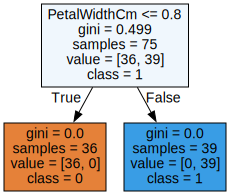

In [6]:
import pandas as pd
import dtreeviz
#from dtreeviz.trees import dtreeviz
import graphviz
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.preprocessing import LabelEncoder

# 深さ4の決定木を構築
clf = tree.DecisionTreeClassifier(max_depth=4)
clf.fit(X, y)
# 木を可視化
export_graphviz(
    clf,
    out_file='tree.dot',
    class_names=['0', '1'],
    feature_names=cols_x,
    filled=True
)
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### Reference

[Permutation Importance vs Random Forest Feature Importance (MDI) — scikit-learn 1.2.2 documentation](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)

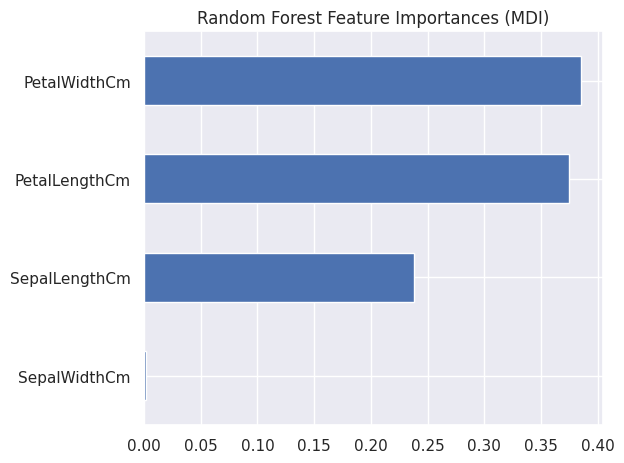

In [7]:
feature_names = X.columns

mdi_importances = pd.Series(
    pipe['RF'].feature_importances_, index=feature_names
).sort_values(ascending=True)
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()
plt.savefig('iris_071_feature_inportance_mdi.png')
plt.show()

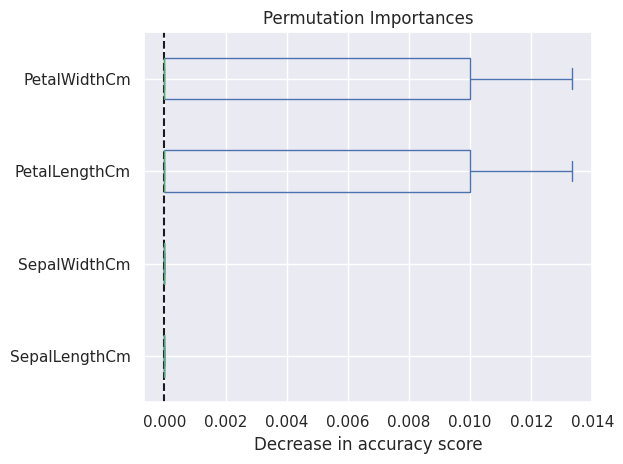

In [8]:
from sklearn.inspection import permutation_importance

result = permutation_importance(pipe, X, y, n_repeats=10, random_state=42, n_jobs=2)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title('Permutation Importances')
ax.axvline(x=0, color='k', linestyle='--')
ax.set_xlabel('Decrease in accuracy score')
ax.figure.tight_layout()
plt.savefig('iris_072_feature_inportance_permutation.png')
plt.show()

In [9]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(pipe)
perm.fit(X, y)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.0080 ± 0.0131,PetalWidthCm
0.0053 ± 0.0131,PetalLengthCm
0 ± 0.0000,SepalWidthCm
0 ± 0.0000,SepalLengthCm


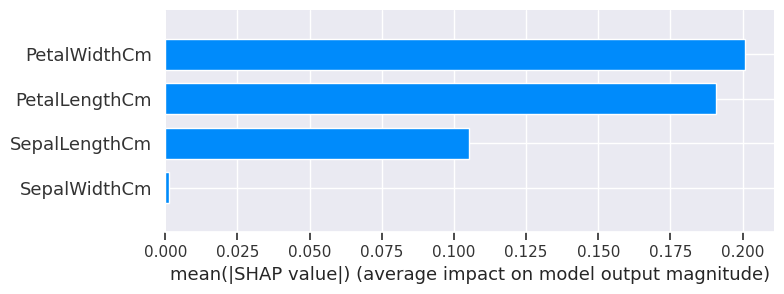

In [10]:
import shap
shap.initjs()

df_cluster_scaled = pd.DataFrame(pipe['scaler'].fit_transform(X), columns=X.columns)

explainer = shap.TreeExplainer(model=pipe['RF'])
shap_values = explainer.shap_values(X=df_cluster_scaled)
shap.summary_plot(shap_values[0], df_cluster_scaled, plot_type="bar", show=False)
plt.savefig('iris_073_feature_inportance_shap.png')
plt.show()

In [11]:
import numpy as np

feature_names = X.columns
result = pd.DataFrame(shap_values[0], columns=feature_names)
vals = np.abs(result.values).mean(0)
shap_importance = pd.DataFrame(
    list(zip(feature_names, vals)),
    columns=['feature name','feature importance']
)
shap_importance.sort_values(
    by=['feature importance'],
    ascending=False,
    inplace=True
)
dfi.export(shap_importance, 'table_075_importances_shap.png')
shap_importance

/usr/bin/google-chrome


,feature name,feature importance
3,PetalWidthCm,0.200834
2,PetalLengthCm,0.190780
0,SepalLengthCm,0.105279
1,SepalWidthCm,0.001161


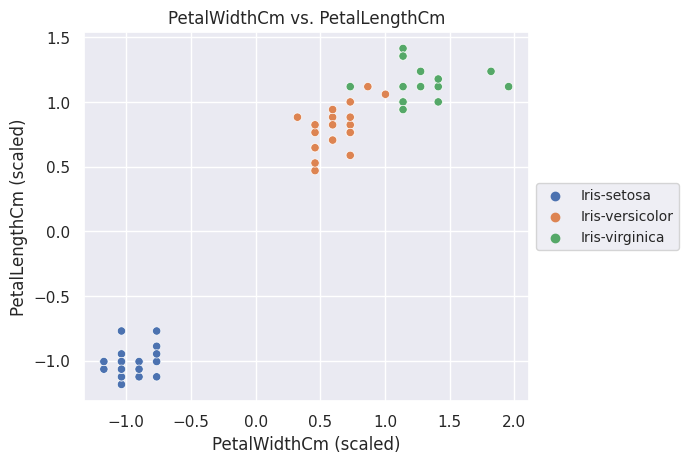

In [12]:
data_x = shap_importance.iloc[0, 0]
data_y = shap_importance.iloc[1, 0]

fig, ax = plt.subplots()
sns.scatterplot(data=df_cluster_scaled, x=data_x, y=data_y, hue=list(df_cluster['Species']), ax=ax)
ax.set_aspect('equal')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.set_title('%s vs. %s' % (data_x, data_y))
ax.set_xlabel('%s (scaled)' % data_x)
ax.set_ylabel('%s (scaled)' % data_y)
plt.savefig('iris_076_top_2_importances.png')
plt.show()